In [32]:
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

class CTRNN():

    def __init__(self, size):
        self.Size = size                        # number of neurons in the circuit
        self.States = np.zeros(size)            # state of the neurons
        self.TimeConstants = np.ones(size)      # time-constant for each neuron
        self.invTimeConstants = 1.0/self.TimeConstants
        self.Biases = np.zeros(size)            # bias for each neuron
        self.Weights = np.zeros((size,size))    # connection weight for each pair of neurons
        self.Outputs = np.zeros(size)           # neuron outputs
        self.Inputs = np.zeros(size)            # external input to each neuron

    def setWeights(self, weights):
        self.Weights =  weights

    def setBiases(self, biases):
        self.Biases =  biases

    def setTimeConstants(self, timeconstants):
        self.TimeConstants =  timeconstants
        self.invTimeConstants = 1.0/self.TimeConstants
        
    def setInputs(self,inputs):
        self.Inputs = inputs #inputs is a np array with a magnitude of tonic input to each neuron in the network

    def randomizeParameters(self):
        self.Weights = np.random.uniform(-10,10,size=(self.Size,self.Size))
        self.Biases = np.random.uniform(-10,10,size=(self.Size))
        self.TimeConstants = np.random.uniform(0.1,5.0,size=(self.Size))
        self.invTimeConstants = 1.0/self.TimeConstants

    def initializeState(self, s): 
        self.States = s
        self.Outputs = sigmoid(self.States+self.Biases)

    def step(self, dt):
        netinput = self.Inputs + np.dot(self.Weights.T, self.Outputs)
        self.States += dt * (self.invTimeConstants*(-self.States+netinput))
        self.Outputs = sigmoid(self.States+self.Biases)
        
    def run(self, duration, dt): #duration in seconds
        self.Outputhist = np.zeros((self.Size,int(duration/dt)))
        for i in range(int(duration/dt)):
            self.step(dt)
            self.Outputhist[:,i] = self.Outputs 
            
    def plot(self,duration, dt,testcase):
        plt.plot(np.arange(0,duration,dt),self.Outputhist[-1],label=testcase)

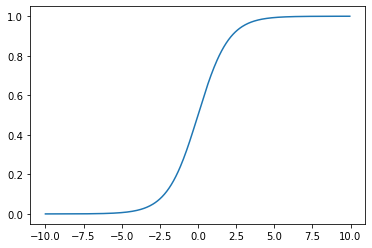

In [3]:
x = np.arange(-10,10,.05)
plt.plot(x,sigmoid(x))

In [4]:
class Generational():

    def __init__(self, fitnessFunction, popsize, genesize, recombProb, mutatProb, generations):
        self.fitnessFunction = fitnessFunction
        self.popsize = popsize
        self.genesize = genesize
        self.recombProb = recombProb
        self.mutatProb = mutatProb
        #self.elite = int(eliteprop*popsize)
        self.generations = generations
        self.pop = np.random.choice(np.array([0,1,-1]),(popsize,genesize))
        #for ind in range(popsize):
            #self.pop[ind] = self.pop[ind]/np.sum(self.pop[ind]) #ensure every genome is a valid probability distribution
        self.fitness = np.zeros(popsize)
        self.rank = np.zeros(popsize,dtype=int)
        self.avgHistory = np.zeros(generations)
        self.bestHistory = np.zeros(generations)
        self.gen = 0

    def showFitness(self):
        plt.plot(self.bestHistory)
        plt.plot(self.avgHistory)
        plt.xlabel("Generations")
        plt.ylabel("Fitness")
        plt.title("Best and average fitness")
        plt.show()

    def fitStats(self):
        bestind = self.pop[np.argmax(self.fitness)]
        bestfit = np.max(self.fitness)
        avgfit = np.mean(self.fitness)
        self.avgHistory[self.gen]=avgfit
        self.bestHistory[self.gen]=bestfit
        return avgfit, bestfit, bestind

    def save(self,filename):
        af,bf,bi = self.fitStats()
        np.savez(filename, avghist=self.avgHistory, besthist=self.bestHistory, bestind=bi)

    def run(self):

        # Calculate all fitness once
        for i in range(self.popsize):
            self.fitness[i] = self.fitnessFunction(self.pop[i])

        # Evolutionary loop
        for g in range(self.generations):

            # Report statistics every generation
            self.gen = g
            self.fitStats()

            # Rank individuals by fitness
            tempfitness = self.fitness.copy()
            for i in range(self.popsize):
                self.rank[i]=int(np.argmax(tempfitness))
                tempfitness[self.rank[i]]=0.0

            # Start new generation
            new_pop = np.zeros((self.popsize,self.genesize))
            new_fitness = np.zeros(self.popsize)

            # Fill out the successful first
            for i in range(int(np.sum(self.fitness))): #for the number of successful
                new_pop[i] = self.pop[self.rank[i]]
                new_fitness[i] = self.fitness[self.rank[i]]

            # Fill out remainder of the population through reproduction of most fit parents
            for i in range(np.count_nonzero(self.fitness),self.popsize):
                if np.sum(self.fitness)!=0:
                    a = np.random.choice(np.count_nonzero(self.fitness))
                    b = np.random.choice(np.count_nonzero(self.fitness))
                    while (a==b):           # Make sure they are two different individuals
                        b = np.random.choice(np.count_nonzero(self.fitness))
                else:
                    a = np.random.choice(self.popsize)
                    b = np.random.choice(self.popsize)
                    while (a==b):
                        b = np.random.choice(self.popsize)                    

                # Recombine parents to produce child
                for k in range(self.genesize):
                    if np.random.random() < self.recombProb:
                        new_pop[i][k] = new_pop[a][k]
                    else:
                        new_pop[i][k] = new_pop[b][k]

                # Mutate child and make sure they stay within bounds
                for k in range(self.genesize):
                    if np.random.random() < self.mutatProb:
                        new_pop[i][k] = np.random.choice(np.array([0,1,-1]),1)
                #new_pop[i] += np.random.normal(0.0,self.mutatProb,size=self.genesize)
                #new_pop[i] = new_pop[i]/np.sum(new_pop[i]) #ensure it remains a valid probability distribution

                # Recalculate their fitness
                new_fitness[i] = self.fitnessFunction(new_pop[i])

            # Finally replace old population with the new one
            self.pop = new_pop.copy()
            self.fitness = new_fitness.copy()
            
        

In [44]:
#Exhaustively list all possible configurations of the 3x3 adjacency matrix

def find_ternary(num): #represents a number as a string in ternary
    quotient = num/3    
    remainder = num%3
    if quotient == 0:   
        return ""
    else:
        return find_ternary(int(quotient)) + str(int(remainder))

adj_mats = np.zeros((19683,3,3)) #master list
for i in range(19683):
    ternary = np.array(list(map(int, find_ternary(i))))
    adj_mats[i]=np.reshape(np.pad(ternary,(9-len(ternary),0),'constant'),(3,3))
    adj_mats[i] = adj_mats[i] - np.ones((3,3)) #subtract 1 from every ternary digit to translate the possibilities from 012 to -101
    


In [13]:
magnitude = 1. #magnitude of the tonic input given to the "on" neurons
def logictest(C,initstate,logic,plotting): #C is an object of the CTRNN class, initstate is an array of inital state values for each neuron
    testcase00 = np.zeros(C.Size)
    testcase01 = np.zeros(C.Size)
    testcase01[1] = magnitude
    testcase10 = np.zeros(C.Size)
    testcase10[0] = magnitude
    testcase11 = np.zeros(C.Size)
    testcase11[0:2] = magnitude
    output = []
    C.setInputs(testcase00)
    C.initializeState(initstate) 
    C.run(100,.1)
    if plotting == True:
        C.plot(100,.1,"00")
        print(C.Outputs[-1])
    output.append(C.Outputs[-1]>0.5)
    C.setInputs(testcase01)
    C.initializeState(initstate) 
    C.run(100,.1)
    if plotting == True:
        C.plot(100,.1,"01")
        print(C.Outputs[-1])
    output.append(C.Outputs[-1]>0.5)
    C.setInputs(testcase10)
    C.initializeState(initstate) 
    C.run(100,.1)
    if plotting == True:
        C.plot(100,.1,"10")
        print(C.Outputs[-1])
    output.append(C.Outputs[-1]>0.5)
    C.setInputs(testcase11)
    C.initializeState(initstate)
    C.run(100,.1)
    if plotting == True:
        C.plot(100,.1,"11")
        print(C.Outputs[-1])
        plt.legend()
        plt.show()
    output.append(C.Outputs[-1]>0.5)
    if logic == 'or':
        correctanswer = [0,1,1,1]
    if logic == 'and':
        correctanswer = [0,0,0,1]
    if logic == 'xor':
        correctanswer = [0,1,1,0]
    if logic == 'nand':
        correctanswer = [0,0,0,1]
    if logic == 'nor':
        correctanswer = [1,0,0,0]
    if logic == 'xnor':
        correctanswer = [1,0,0,1]
    if output == correctanswer:  #based on the logic gate you're trying to match
        success = 1
    else:
        success = 0
    return output, correctanswer, success

In [49]:
#Generate random circuits (or run through all 3-neuron motifs) and test for logic gate activity
#samp_size = 10000
circuit_size = 3 #####changed for motif testing
genome_size = circuit_size**2
#sample = np.random.choice(np.array([0,1,-1]),(samp_size,genome_size))
#print(sample[0:5])

or_genomes = [] #initialize list to hold successful "and gate" genomes

def successcounter(genome): #instantiate genetically specified circuit and run from 11 initial conditions between -10 and 10 and return percentage of correct classifications
    C = CTRNN(circuit_size)
    C.setWeights(np.reshape(genome,(circuit_size,circuit_size)))
    C.setBiases(np.zeros(circuit_size))
    C.setTimeConstants(np.ones(circuit_size))
    initstates = np.arange(-1,2,1) #range of initial states, same for all neurons
    successes = 0 #initialize success counter
    for i in initstates:
        #print('init',initstates[i])
        successful_init_state = logictest(C,initstates[i]*np.ones(C.Size),'or',False)[2]
        successes += successful_init_state
        if successful_init_state != 0:
            #logictest(C,initstates[i]*np.ones(C.Size),'and',True)
            print('good genome =', genome)
    if successes != 0:
        or_genomes.append(list(genome))
    return successes


successcount = np.zeros(len(adj_mats))
for i in range(len(adj_mats)): ####changed for motif testing
    successcount[i] = successcounter(adj_mats[i]) ###changed for motif testing
            

good genome = [[-1. -1.  1.]
 [ 1. -1.  0.]
 [ 0.  1. -1.]]
good genome = [[-1. -1.  1.]
 [ 1. -1.  0.]
 [ 0.  1. -1.]]
good genome = [[-1. -1.  1.]
 [ 1. -1.  0.]
 [ 0.  1. -1.]]
good genome = [[-1. -1.  1.]
 [ 1.  0.  0.]
 [ 0.  0. -1.]]
good genome = [[-1. -1.  1.]
 [ 1.  0.  0.]
 [ 0.  0. -1.]]
good genome = [[-1. -1.  1.]
 [ 1.  0.  0.]
 [ 0.  0. -1.]]
good genome = [[-1. -1.  1.]
 [ 1.  0.  0.]
 [ 0.  1. -1.]]
good genome = [[-1. -1.  1.]
 [ 1.  0.  0.]
 [ 0.  1. -1.]]
good genome = [[-1. -1.  1.]
 [ 1.  0.  0.]
 [ 0.  1. -1.]]
good genome = [[-1. -1.  1.]
 [ 1.  1.  0.]
 [ 0. -1. -1.]]
good genome = [[-1. -1.  1.]
 [ 1.  1.  0.]
 [ 0. -1. -1.]]
good genome = [[-1. -1.  1.]
 [ 1.  1.  0.]
 [ 0. -1. -1.]]
good genome = [[-1. -1.  1.]
 [ 1.  1.  0.]
 [ 0.  0. -1.]]
good genome = [[-1. -1.  1.]
 [ 1.  1.  0.]
 [ 0.  0. -1.]]
good genome = [[-1. -1.  1.]
 [ 1.  1.  0.]
 [ 0.  0. -1.]]
good genome = [[-1.  0.  1.]
 [ 1. -1.  0.]
 [ 0.  0. -1.]]
good genome = [[-1.  0.  1.]
 [ 1. -1.  

good genome = [[ 1.  1.  0.]
 [-1. -1.  1.]
 [-1.  0. -1.]]
good genome = [[ 1.  1.  0.]
 [-1. -1.  1.]
 [-1.  0. -1.]]
good genome = [[ 1.  1.  0.]
 [-1. -1.  1.]
 [-1.  0. -1.]]
good genome = [[ 1.  1.  0.]
 [-1. -1.  1.]
 [ 0.  0. -1.]]
good genome = [[ 1.  1.  0.]
 [-1. -1.  1.]
 [ 0.  0. -1.]]
good genome = [[ 1.  1.  0.]
 [-1. -1.  1.]
 [ 0.  0. -1.]]
good genome = [[ 1.  1.  0.]
 [-1.  0.  1.]
 [-1. -1. -1.]]
good genome = [[ 1.  1.  0.]
 [-1.  0.  1.]
 [-1. -1. -1.]]
good genome = [[ 1.  1.  0.]
 [-1.  0.  1.]
 [-1. -1. -1.]]
good genome = [[ 1.  1.  0.]
 [-1.  0.  1.]
 [ 0. -1. -1.]]
good genome = [[ 1.  1.  0.]
 [-1.  0.  1.]
 [ 0. -1. -1.]]
good genome = [[ 1.  1.  0.]
 [-1.  0.  1.]
 [ 0. -1. -1.]]
good genome = [[ 1.  1.  0.]
 [ 0. -1.  1.]
 [-1.  0. -1.]]
good genome = [[ 1.  1.  0.]
 [ 0. -1.  1.]
 [-1.  0. -1.]]
good genome = [[ 1.  1.  0.]
 [ 0. -1.  1.]
 [-1.  0. -1.]]
good genome = [[ 1.  1.  0.]
 [ 0.  0.  1.]
 [-1. -1. -1.]]
good genome = [[ 1.  1.  0.]
 [ 0.  0.  

In [50]:
#Save the good genomes/motifs to a csv file

with open('ormotifs.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(or_genomes)

0.7310585786300051
0.7740037965825924
0.7740037965825927
0.8118562749129377


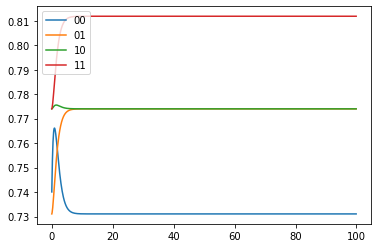

0.7310585786300048
0.7740037965825924
0.7740037965825927
0.8118562749129377


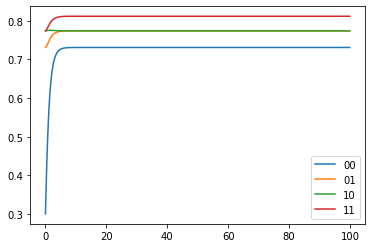

0.7310585786300048
0.7740037965825924
0.7740037965825927
0.8118562749129377


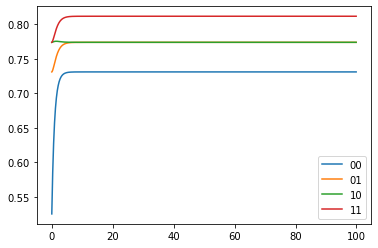

genome = [[0 0 1]
 [0 0 1]
 [0 0 0]] success = 0


In [67]:
#Test any genome for any logic operation with plotting 
#or_genomes = np.genfromtxt('orgenomes.csv',delimiter=',')
C = CTRNN(3)
#genome = np.array([0,0,1,1,0,0,0,1,-1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0])
genome = np.array([[0,0,1],[0,0,1],[0,0,0]])
C.setWeights(np.reshape(genome,(3,3)))
C.setBiases(np.zeros(3))
C.setTimeConstants(np.ones(3))
initstates = np.arange(-1,2,1) #range of initial states, same for all neurons
successes = 0 #initialize success counter
for i in initstates:
    #print('init',initstates[i])
    successful_init_state = logictest(C,initstates[i]*np.ones(C.Size),'or',True)[2]
    successes += successful_init_state
    if successful_init_state != 0:
        logictest(C,initstates[i]*np.ones(C.Size),'or',True)
print('genome =', genome, 'success =', successes)

In [141]:
#running the genetic algorithm
popsize = 10
recombProb = .2
mutatProb = .05
generations = 15
G = Generational(fitnessfuncnullmodel, popsize, size*size, recombProb, mutatProb, generations)
G.run()
G.showFitness()

In [66]:
#Randomly generate 5x5 genomes with ~ same E/I ratio as the successful AND gate, OR gates, and aggregate of both
sampsize = 59 #same number of random circuits as what you are comparing it to 
and_props = [0.3025,0.33,0.3675] #proportion of 0,1,-1 in the successful AND genomes
or_props = [0.3193220338983051, 0.31457627118644066, 0.36610169491525424] #"" OR genomes
aggregate_props = [0.3134065934065934,0.32,0.3665934065934066] #"" in all the successful genomes
randomgenomes = np.random.choice(np.array([0,1,-1]),(sampsize,25),p=or_props)

#Save this sample of graphs as csv file 
with open('59randomgenomes.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(randomgenomes)

In [23]:
#scratch cell

A=np.arange(-10,11,2)
A

array([-10,  -8,  -6,  -4,  -2,   0,   2,   4,   6,   8,  10])